Device: mps
Loading control model: qualifire/prompt-injection-jailbreak-sentinel-v2...
Running benchmark...


100%|██████████| 500/500 [00:44<00:00, 11.11it/s]


Total Samples: 500
Accuracy: 0.9820
Avg Confidence on WRONG answers: 0.8581
Approximate ECE: 0.2020


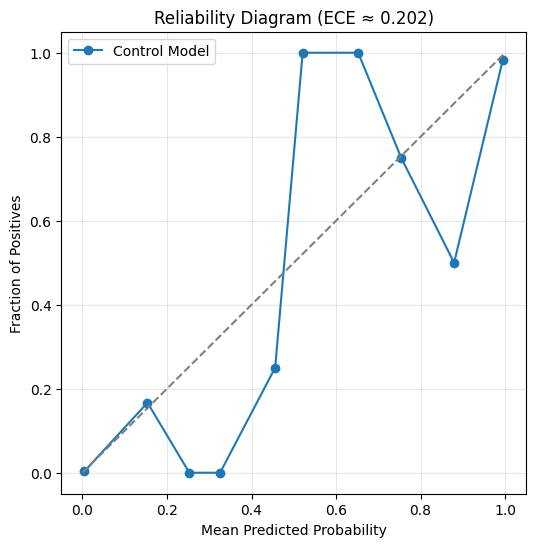

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from tqdm import tqdm
from sklearn.calibration import calibration_curve

# --- CONFIG ---
CONTROL_MODEL_NAME = "qualifire/prompt-injection-jailbreak-sentinel-v2"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
MAX_SAMPLES = 500

print(f"Device: {DEVICE}")

# --- SETUP MODEL ---
print(f"Loading control model: {CONTROL_MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(CONTROL_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(CONTROL_MODEL_NAME, torch_dtype=torch.float16)
model.to(DEVICE)
model.eval()

# --- HELPER FUNCTIONS ---
def parse_label(value):
    if isinstance(value, int): return value
    if isinstance(value, str):
        v = value.lower()
        if v in ["jailbreak", "malicious", "unsafe", "attack", "injection", "1"]: return 1
        if v in ["benign", "safe", "legit", "0"]: return 0
    try: return int(value)
    except: return 0

def get_prediction(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)
        # Assuming index 1 is malicious
        return probs[0][1].item()
    except Exception as e:
        print(f"Error: {e}")
        return 0.5

# --- DATASET & INFERENCE ---
ds = load_dataset("qualifire/prompt-injections-benchmark", split="test")
ds = ds.shuffle(seed=42).select(range(min(len(ds), MAX_SAMPLES)))

results = []
print("Running benchmark...")

for ex in tqdm(ds):
    text = ex.get('text') or ex.get('prompt')
    if not text: continue
    
    label = parse_label(ex['label'])
    prob_malicious = get_prediction(text)
    
    # Simple thresholding at 0.5 for the control model
    pred_label = 1 if prob_malicious > 0.5 else 0
    confidence = prob_malicious if pred_label == 1 else (1 - prob_malicious)
    
    results.append({
        "label": label,
        "prob_malicious": prob_malicious,
        "prediction": pred_label,
        "confidence": confidence,
        "is_correct": (pred_label == label)
    })

df = pd.DataFrame(results)

# --- ANALYSIS ---
print(f"\nTotal Samples: {len(df)}")
print(f"Accuracy: {df['is_correct'].mean():.4f}")

# Overconfidence on Errors
wrong_df = df[~df['is_correct']]
avg_conf_wrong = wrong_df['confidence'].mean() if not wrong_df.empty else 0
print(f"Avg Confidence on WRONG answers: {avg_conf_wrong:.4f}")

# ECE Calculation
probs = np.array(df["prob_malicious"])
labels = np.array(df["label"])
prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)

# Weighted ECE approximation
ece = np.mean(np.abs(prob_true - prob_pred)) 
print(f"Approximate ECE: {ece:.4f}")

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Control Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Reliability Diagram (ECE ≈ {ece:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()